### Task 1

The data set I will be using to solve a classification test is the CIFAR-10
dataset that can be found here: https://www.cs.toronto.edu/~kriz/cifar.html.
This data set contains 60,000 32 by 32 images with 10 different
classifications: airplane, automobile, bird, cat, deer, dog, frog, horse, ship,
and truck. 

#### Part 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import ssl
from tqdm import tqdm

ssl._create_default_https_context = ssl._create_unverified_context
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Below, I create a transform for the image data. Currently, all I am doing is
normalizing the pixel data.

In [3]:
transform_fn = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5, .5, .5),
                                                                               (.5, .5, .5))])
batches = 4

train_data = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_fn)
test_data = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_fn)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batches, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batches, shuffle=False, num_workers=2)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


Below, I display example 3 images and their labels. They are 32 by 32, which is why they appear very pixelated. A lower dimensional image will help with training time.

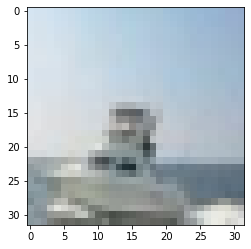

ship


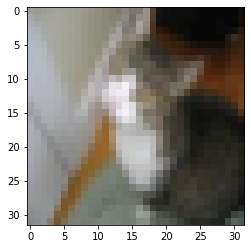

cat


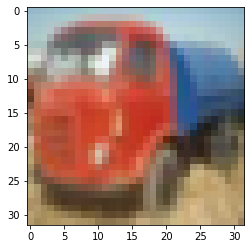

truck


In [4]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i in range(100,103):
    train_loader.dataset[i][0]
    imshow(torchvision.utils.make_grid(train_loader.dataset[i][0]))
    print(classes[train_loader.dataset[i][1]])

Below a basic CNN model is designed. I wanted to keep it very simple, so the
training time is feasible, and I could use a reasonable number of epochs. The
model consists of a convolution with three input channels, six output channels,
and a kernel size of 5. That is then fed into a max pooling layer to reduce
dimensionality. Then, there is one more convolution layer with six input
channels, sixteen output channels, and a kernel size of 5. The convolutions
allow the network to learn about a specifc part of the image, or a certain
trait of the image. Finally, this is fed into a dense layer which is just a
straightforward feed-forward with ReLU activations. 

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16 * 5 * 5, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        return self.linear_relu_stack(x)


model = CNN()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
epochs = 15

Below, you can see that after every epoch, the accuracy for the training data
increases substantially but eventually starts to taper off. For the loss vs
iteration, the plot just diplays a bunch of noise; however, the minimums of
period of iterations seem to decrease, implying convergence. 

epoch: 0, loss: 2.420
train accuracy: 43.706 %
epoch: 1, loss: 0.617
train accuracy: 55.346 %
epoch: 2, loss: 1.906
train accuracy: 59.71 %
epoch: 3, loss: 0.393
train accuracy: 62.62 %
epoch: 4, loss: 0.427
train accuracy: 64.838 %
epoch: 5, loss: 0.929
train accuracy: 66.56 %
epoch: 6, loss: 0.537
train accuracy: 68.064 %
epoch: 7, loss: 0.230
train accuracy: 69.404 %
epoch: 8, loss: 0.582
train accuracy: 70.562 %
epoch: 9, loss: 0.827
train accuracy: 71.586 %
epoch: 10, loss: 0.090
train accuracy: 72.478 %
epoch: 11, loss: 0.571
train accuracy: 73.152 %
epoch: 12, loss: 1.694
train accuracy: 74.04 %
epoch: 13, loss: 0.241
train accuracy: 74.834 %
epoch: 14, loss: 0.528
train accuracy: 75.638 %


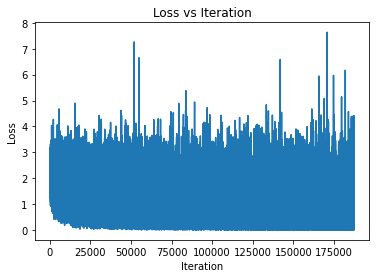

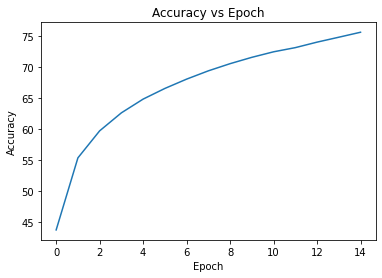

In [28]:
torch.cuda.empty_cache()
error = []
accuracy = []
for epoch in range(epochs):
    total = 0
    correct = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        error.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
        if i == 0:
            print(f'epoch: {epoch}, loss: {loss.item():.3f}')
    accuracy.append(100*correct/total)
    print(f'train accuracy: {accuracy[-1]} %')

plt.figure()
plt.title("Loss vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(error)
    
plt.figure()
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracy)
plt.show()

In [30]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
print(f'train accuracy: {100*correct/total} %')

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
print(f'test accuracy: {100*correct/total} %')

train accuracy: 75.058 %
test accuracy: 60.32 %


Above are the results for the training data and testing data. The metric I am
using is accuracy, so the number of correctly predicted images over the total
number of images. We can see that train accuracy is much higher than the test
accuracy, implying that there is overfitting occuring. 

#### Part 2

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


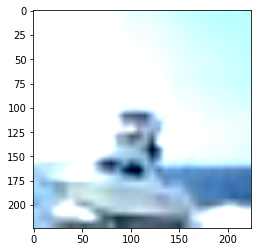

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


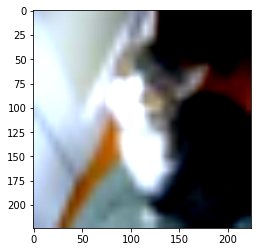

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


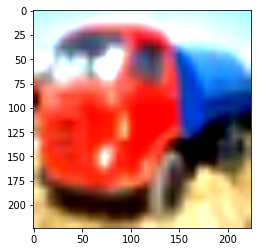

truck


In [44]:
transform_fn = transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406),
                                                        (0.229, 0.224, 0.225))])

batches = 4

train_data = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_fn)
test_data = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_fn)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batches, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batches, shuffle=False, num_workers=2)

for i in range(100,103):
    train_loader.dataset[i][0]
    imshow(torchvision.utils.make_grid(train_loader.dataset[i][0]))
    print(classes[train_loader.dataset[i][1]])

Below, I use the MobileNetV2 architecture along with pre-trained weights.

In [39]:
trans_model = torchvision.models.mobilenet_v2(weights=torchvision.models.mobilenetv2.MobileNet_V2_Weights.DEFAULT)
trans_model.classifier[1] = nn.Linear(trans_model.classifier[1].in_features, 10)
trans_model = trans_model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(trans_model.parameters(), lr=.001)

epoch: 0, loss: 2.319
train accuracy: 66.868 %
epoch: 1, loss: 1.001
train accuracy: 75.896 %
epoch: 2, loss: 0.344
train accuracy: 80.572 %
epoch: 3, loss: 0.249
train accuracy: 83.438 %
epoch: 4, loss: 0.036
train accuracy: 85.594 %
epoch: 5, loss: 0.449
train accuracy: 87.244 %
epoch: 6, loss: 0.075
train accuracy: 88.34 %
epoch: 7, loss: 0.055
train accuracy: 89.59 %


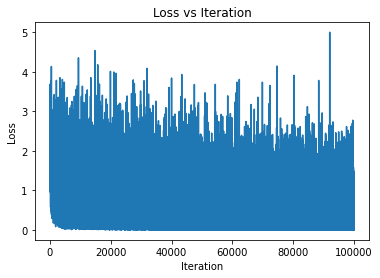

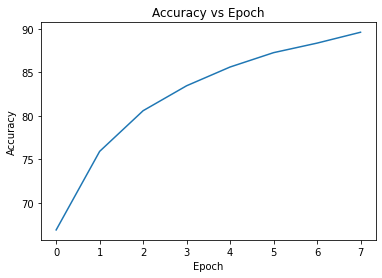

In [45]:
torch.cuda.empty_cache()
error = []
accuracy = []
for epoch in range(8):
    total = 0
    correct = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = trans_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        error.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
        if i == 0:
            print(f'epoch: {epoch}, loss: {loss.item():.3f}')
    accuracy.append(100*correct/total)
    print(f'train accuracy: {accuracy[-1]} %')

plt.figure()
plt.title("Loss vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(error)
    
plt.figure()
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracy)
plt.show()

In [46]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = trans_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
print(f'train accuracy: {100*correct/total} %')

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = trans_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
print(f'test accuracy: {100*correct/total} %')

train accuracy: 89.614 %
test accuracy: 85.36 %


Above are the results of the transfer learning model, which I made use of the
MobileNetV2 architecture and weights. As we can see, both the train and test
accuracy are higher than the model in part 1. Additionally, there is much less
overfitting occurring: the test accuracy is much closer to the training
accuracy. 

This difference in results is expected. The MobileNetV2 architecture is much
more complex, and preset weights are a result of training the network on
extensive dataset for a very large number of iterations. As a result, this
network is much better at classifying images from the get-go. Additionally,
notice that we only trained the network for eight epochs, while we trained the
network in part 1 for fifteen epochs (due to training time), and the results
are still much better. 

#### Part 3

Below, I adjust the transformation function from part 1. Now, I add two methods, RandomVerticalFlip() and RandomHorizontalFlip(), which will randomly flip the images along the centered x and y axes.

In [5]:
transform_fn = transforms.Compose([transforms.ToTensor(),
                                   transforms.RandomVerticalFlip(),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.Normalize((.5, .5, .5),
                                                        (.5, .5, .5))])
batches = 4

train_data = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_fn)
test_data = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_fn)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batches, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batches, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


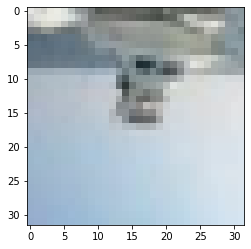

ship


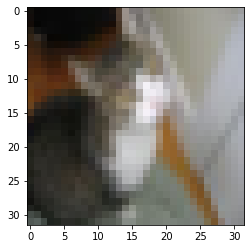

cat


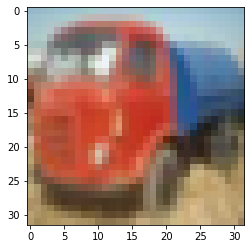

truck


In [11]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i in range(100,103):
    train_loader.dataset[i][0]
    imshow(torchvision.utils.make_grid(train_loader.dataset[i][0]))
    print(classes[train_loader.dataset[i][1]])

In [9]:
model2 = CNN()
model2 = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
epochs = 15

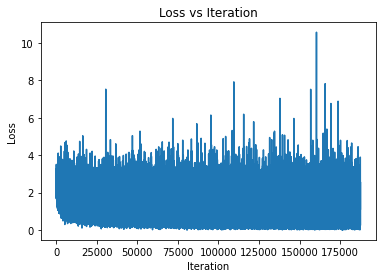

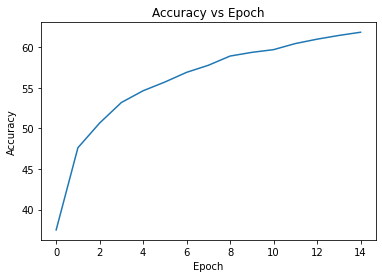

In [10]:
torch.cuda.empty_cache()
error = []
accuracy = []
for epoch in range(epochs):
    total = 0
    correct = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        error.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
    accuracy.append(100*correct/total)

plt.figure()
plt.title("Loss vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(error)
    
plt.figure()
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracy)
plt.show()

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
print(f'train accuracy: {100*correct/total} %')

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
print(f'test accuracy: {100*correct/total} %')

train accuracy: 61.152 %
test accuracy: 58.03 %


Above are the results for the training and testing data. Comparing the results
to part 1, we can see that the training accuracy is much lower (61% vs. 75%),
but the test accuracy is about the same (58% vs 60%). Notice that even though
the training accuracy is much lower, the test accuracy is almost the same as in
part 1. Also, notice that the training accuracy is much closer to the test
accuracy than in part 1 (3% vs. 15%). Basically, we see that the network is not
overfitting compared to the model in part 1. This is due to the random
transformations we applied to the training data. Those transformations (random
vertical and horizontal flip) allow the model to generalize much better to
different image formats, and we can see it did a pretty good job. 

### Task 2

#### Part 1

#### Part 2